# Evolution of Psychology Research  
#### Final Project
**Large-Scale Computing for the Social Sciences**   
**MACS 30123, Spring 2020**   
**Tianyue Niu**

Brief Project Description:  

    In this final project, I intend to explore the changes in past research trends using PubMed publication data that is readily accesible from PubMed database. In particular, I intend to focus on psychology-related PubMed articles. Psychology has many different divisions, including but not limited to abnormal psychology,neuroscience, cognition, early development, etc. By analyzing publications content, we will be able to learn more about past research trends. I believe this is interesting and meaningful to look into because 1) with this result, psychologists can concentrate their research efforts on certain domains to make larger collective progress, 2)the change in focus in psychology can also be reflective of changes in cultural trend (e.g. how we view psychologically abnormal patients, or are we focusing more on self-care than in the past, etc), which can have significant sociological or economic implications. 
        
    Given the background, the questions that I aim to answer with this project is 'How has the focus of psychological research changed in the last 50 years?'. In order to answer this question, I intend to perform word-embedding analysis for two specific topics, mental health and alzheimer, to evalute changes in our understanding of these topics across time. I also intend to perform topic modeling analysis on publication abstracts from different period, and compare changes in research focus from a macro perspective.


(PubMed Baseline File: ftp://ftp.ncbi.nlm.nih.gov/pubmed/baseline)

## Loading Data

**Download Data & Preliminary Processing**

    Raw xml files were downloaded from pubmed database. The files were then parsed and changed into a dataframe that kept only psychology-related publications with non-null abstracts. These steps were performed on an EC2 instance.
    
    The following bash commands were used to install packages and configure aws on EC2:

In [ ]:
$ sudo apt update
$ sudo apt install python3-pip
$ pip3 install pandas
$ pip3 install numpy
$ pip3 install --user git+http://github.com/titipata/pubmed_parser.git
$ sudo apt install awscli
$ aws configure
$ nano ~/.aws/credentials 

    The following script.py file was run on EC2 (launched a t2.2xlarge because the function below requires a larger memory to parse xml files). 
    
    The function below is used to process 127 xml files (each approximately 30 MB). After selecting interested columns and filtering out non-psychology related articles, the final csv file created is about 450MB large.

In [15]:
#saved as script.py

#import necessary packages for data processing
import ftplib # !pip install --user git+http://github.com/titipata/pubmed_parser.git
import pubmed_parser as pp
import numpy as np
import pandas as pd

#large scale computing
import time

ftp = ftplib.FTP("ftp.ncbi.nlm.nih.gov")
ftp.login("anonymous", "tniu@uchicago.edu")

ftp.cwd("/pubmed/baseline")
pubmed_files = ftp.nlst() # get list of filenames
ftp.quit()

#find files
files = [f for f in pubmed_files if f.endswith("xml.gz")]
#There are a total of 1015 files (publication organized by time), for cost concerns, 
#I will only download one of every eight files (approximately 127 files)
files = files[0::8]

#define function for downloading and process files
def download_process_data(files):
    
    final_df = pd.DataFrame(columns=['title','abstract','authors','pubdate',
                                     'keywords','doi','country','journal','flag_psyc'])
    # filtering criteria: psyc-related abstract
    psych_keywords = ['psych','neur','alzheimer','Alzheimer'] #we particularly want to look at Alzheimer
    
    def isPsych(abstract, keywords):
        #flag psychology articles based on keywords
        return any(word in abstract for word in keywords)
    
    for filename in files:
        start = time.time()
        # access ftp
        ftp = ftplib.FTP("ftp.ncbi.nlm.nih.gov")
        ftp.login("anonymous", "tniu@uchicago.edu")
        ftp.cwd("/pubmed/baseline")
        # download xml file
        with open(filename, "wb") as f:
            ftp.retrbinary("RETR " + filename, f.write)
        ftp.quit()
        # do parsing
        pubmed_parsed = pp.parse_medline_xml("./" + filename)
        #select interested columns
        pubmed_df = pd.DataFrame(pubmed_parsed)[['title','abstract','authors','pubdate',
                                                 'keywords','doi','country','journal']]
        psyc_flag = pd.DataFrame(index=pubmed_df.index, columns=['flag_psyc'], dtype=object)
        for row in pubmed_df.itertuples():
            #flag pschology articles
            psyc_flag.at[row.Index, 'flag_psyc'] = isPsych(row.abstract + row.title, psych_keywords)
        #combine flag column with original df
        combined_df = pd.concat([pubmed_df, psyc_flag], axis = 1)
        #keep only psychology-related articles with abstracts
        psyc = combined_df.query('abstract != "" and flag_psyc == True')
        print("Time taken for", filename, ":", time.time()-start, "seconds")
        final_df = final_df.append(psyc, ignore_index=True, sort=False)

    return final_df.reset_index(drop=True)


#download and process 100 files from pubmed
df = download_process_data(files)

#save the data as a csv
df.to_csv('data.csv', encoding='utf-8')

In [ ]:
$ python3 script.py

First few lines of output:

    Time taken for pubmed20n0003.xml.gz : 18.616763830184937 seconds
    Time taken for pubmed20n0011.xml.gz : 18.065609455108643 seconds
    Time taken for pubmed20n0017.xml.gz : 16.61393094062805 seconds
    Time taken for pubmed20n0025.xml.gz : 15.993685483932495 seconds
    Time taken for pubmed20n0033.xml.gz : 16.41616153717041 seconds
    Time taken for pubmed20n0041.xml.gz : 15.886789798736572 seconds
    Time taken for pubmed20n0049.xml.gz : 19.594257354736328 seconds
    Time taken for pubmed20n0059.xml.gz : 19.029791831970215 seconds
    Time taken for pubmed20n0065.xml.gz : 19.350542068481445 seconds
    ......

**Store to S3**

In [ ]:
#move data.csv to s3
$ aws s3 cp data.csv s3://selina-pywren-338/pubmed-psyc-data/

    The final data stored on s3 contains 299315 psychology-related publication abstracts from 1927 to 2019

## Launch EMR to run text analysis using PySpark
Method used:
1. Topic Modeling: compare 'trendy' research topics across years
2. Word Embedding: analyze changes of embedding for specific topics over years

**Launching an EMR Notebook**  
*The following codes were run on an EMR notebook using PySpark:*

In [ ]:
#install necessary packages
sc.install_pypi_package("pandas")
sc.install_pypi_package("s3fs")
sc.install_pypi_package("boto3")

# import necessary packages
import re as re
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import Word2Vec
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
from pyspark.sql.functions import udf
from pyspark.sql.types import *
import boto3
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#check version
sc.version

## Topic Modeling Analysis
**Comparison of key research topics across years**

In [3]:
#read in data from S3
data = spark.read.csv("s3n://selina-pywren-338/pubmed-psyc-data/data.csv", header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
data.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+--------------------+--------------------+--------------------+-------+--------+--------------------+-------------+--------------------+---------+
|_c0|               title|            abstract|             authors|pubdate|keywords|                 doi|      country|             journal|flag_psyc|
+---+--------------------+--------------------+--------------------+-------+--------+--------------------+-------------+--------------------+---------+
|  0|Multiple sclerosi...|To investigate th...|T Tabira;HD Webst...|   1976|    null|10.1056/NEJM19760...|United States|The New England j...|     True|
|  1|Electron microsco...|By application of...|H Castejón;OJ Cas...|   1976|    null|10.1016/s0065-128...|      Germany|   Acta histochemica|     True|
|  2|Neurohistological...|An investigation ...|           RS Purwar|   1976|    null|   10.1159/000144669|  Switzerland|      Acta anatomica|     True|
|  3|Whipple's disease...|Whipple's disease...|SW Silbert;E Park...|   1976|    null|  1

In [5]:
data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- _c0: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- pubdate: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- country: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- flag_psyc: string (nullable = true)

In [6]:
df = data.withColumn("year", data["pubdate"].cast(IntegerType()))
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- _c0: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- pubdate: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- country: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- flag_psyc: string (nullable = true)
 |-- year: integer (nullable = true)

In [7]:
#create new data by year
data_before70 =  df.filter("year < 1970")
data_before70.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------------------+--------------------+--------------------+-------+--------+--------------------+-------------+--------------------+---------+----+
|  _c0|               title|            abstract|             authors|pubdate|keywords|                 doi|      country|             journal|flag_psyc|year|
+-----+--------------------+--------------------+--------------------+-------+--------+--------------------+-------------+--------------------+---------+----+
|32236|The antigenic rel...|Segregation of th...|JL Schulman;ED Ki...|   1969|    null|                null|  Switzerland|Bulletin of the W...|     True|1969|
|32237|Relationship of e...|This study demons...|B Tumova;BC Easte...|   1969|    null|                null|  Switzerland|Bulletin of the W...|     True|1969|
|32239|The role of antin...|Experimental stud...|         JL Schulman|   1969|    null|                null|  Switzerland|Bulletin of the W...|     True|1969|
|32254|Some clinical and...|This study was de.

In [8]:
#create new data by year
data_7080 = df.filter("year >= 1970 and year < 1980")
data_8090 = df.filter("year >= 1980 and year < 1990")
data_9000 =  df.filter("year >= 1990 and year < 2000")
data_0010 = df.filter("year >= 2000 and year < 2010")
data_after10 =  df.filter("year >= 2010")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
customized_stop_words = ['use','used', 'case','study','studies','aim',
                         'investigate','find','findings','data','authors',
                         'different','group','groups','year','years','method',
                         'determine','assess','examine','rate','result','level',
                         'effect','process']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
nltk = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
        "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
        'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
        'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 
        'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 
        'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 
        'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
        'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 
        'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 
        'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 
        'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 
        'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 
        'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 
        'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 
        'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 
        's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 
        'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 
        'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 
        'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', 
        "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 
        'shouldn', "shouldn't", 'wasn',"wasn't", 'weren', "weren't", 'won', "won't", 
        'wouldn', "wouldn't"]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
StopWords = customized_stop_words + nltk

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [98]:
def create_tokens(StopWords, data):
    #customize create tokens for more accurate results
    tokens = data.rdd.map(
        lambda x : x['abstract']).filter(
        lambda x: x is not None).map(
        lambda document: document.strip().lower()).map(
        lambda document: re.split(" ", document)).map(
        lambda word: [x for x in word if x.isalpha()]).map(
        lambda word: [x for x in word if len(x) > 2]).map(
        lambda word: [x for x in word if x not in StopWords]).zipWithIndex()

    return tokens

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [136]:
tokens_before70 = create_tokens(StopWords,data_before70)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [138]:
#create a dataframe
before70_text = sqlContext.createDataFrame(tokens_before70, ["list_of_words",'index'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [145]:
#check the data
before70_text.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|       list_of_words|index|
+--------------------+-----+
|[segregation, hae...|    0|
|[demonstrates, re...|    1|
|[experimental, mi...|    2|
|[designed, evalua...|    3|
|[psychotic, condi...|    4|
+--------------------+-----+
only showing top 5 rows

In [211]:
#count term frequency, vocab size = 5000, ignore terms that appear in more than 80% of the articles
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, maxDF=0.8)
cv_model = cv.fit(before70_text) #will use this to create vocab list
result_cv = cv_model.transform(before70_text)

#get inverse document frequency
idf = IDF(inputCol="raw_features", outputCol="features")
tfidf = idf.fit(result_cv).transform(result_cv) 
tfidf.select("index", "features").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------------------+
|index|            features|
+-----+--------------------+
|    0|(4832,[72,89,94,9...|
|    1|(4832,[25,44,71,8...|
|    2|(4832,[13,19,22,3...|
|    3|(4832,[2,19,33,34...|
|    4|(4832,[8,18,26,39...|
+-----+--------------------+
only showing top 5 rows

In [159]:
#train LDA using tfidf matrix, setting number of clusters = 8 and maxIteration = 50
lda = LDA(k=8, maxIter=50) #chose k=8 topics
model = lda.fit(tfidf.select('index','features')) #took a while to run

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [163]:
#check topics
model.describeTopics().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[239, 360, 94, 34...|[0.01146516490556...|
|    1|[2, 82, 7, 605, 1...|[0.00624738258028...|
|    2|[5, 61, 465, 0, 9...|[0.00891512206649...|
|    3|[27, 12, 334, 177...|[0.01035538170783...|
|    4|[205, 761, 504, 4...|[0.01271706536192...|
|    5|[9, 15, 68, 1, 0,...|[0.00931849589324...|
|    6|[304, 541, 115, 1...|[0.01024741270945...|
|    7|[621, 8, 2, 26, 7...|[0.00537508835417...|
+-----+--------------------+--------------------+

In [260]:
topics = model.describeTopics(10) #limit to 10 terms
tRDD = topics.rdd.map(list) #convert to RDD
#define vocab
vocab = cv_model.vocabulary

#define function to extact terms and lda weights
def topic_vocab(topic):
    #print(topic)
    topicNum = topic[0]
    terms = topic[1]
    weight = topic[2]
    result = []
    for i in range(10):
        term = vocab[terms[i]]
        out = str(topicNum) + "," + term + ","+str(weight[i])
        result.append(out)
    return result

#apply the function
topic = tRDD.map(lambda topic: topic_vocab(topic))
res_df = spark.createDataFrame(topic).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [265]:
s3 = boto3.client('s3', aws_access_key_id='HIDDEN', 
                  aws_secret_access_key='HIDDEN')

#save to s3 bucket for future use
res_df.T.to_csv('s3://selina-pywren-338/pubmed-psyc-data/before70_topics.csv')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Now that we know the above procedure works, let's combine everything together to perform topic modeling analysis on data_7080, data_8090, data_9000, data_0010 and data_after10 and store the results to s3:**

In [16]:
#the stop word list is updated with each topic modeling iteration to gain better results
StopWordsUpdated = StopWords + ['provide','evidence','superior','relationships',
                                'general','generally','required','may','phenomena',
                                'cases', 'little','change','strong','pressure','rates', 
                                'one','responses','activity', 'increase', 'increases',
                                'decrease','decreases','increased','decreased','suggest',
                                'suggested','require','required']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
def perform_topic_modeling(StopWords, data):
    
    def create_tokens(StopWords, data):
        #customize create tokens for more accurate results
        tokens = data.rdd.map(
            lambda x : x['abstract']).filter(
            lambda x: x is not None).map(
            lambda document: document.strip().lower()).map(
            lambda document: re.split(" ", document)).map(
            lambda word: [x for x in word if x.isalpha()]).map(
            lambda word: [x for x in word if len(x) > 2]).map(
            lambda word: [x for x in word if x not in StopWords]).zipWithIndex()

        return tokens

    tokens = create_tokens(StopWords,data)

    #create a dataframe
    data_text = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])

    #count term frequency, vocab size = 5000, ignore terms that appear 
    #in more than 80% of the articles
    cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", 
                         vocabSize=5000, maxDF=0.8)
    
    cv_model = cv.fit(data_text) 
    vocab = cv_model.vocabulary #will be used to extract terms in the next function 
    result_cv = cv_model.transform(data_text)

    #get inverse document frequency
    idf = IDF(inputCol="raw_features", outputCol="features")
    tfidf = idf.fit(result_cv).transform(result_cv) 

    #train LDA using tfidf matrix, setting number of clusters = 8 and maxIteration = 50
    lda = LDA(k=8, maxIter=50)
    model = lda.fit(tfidf.select('index','features')) #took a while to run

    return model, vocab

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
def extract_save_terms(model, filename, vocab, keyid, key):
    
    topics = model.describeTopics(10)
    tRDD = topics.rdd.map(list) #convert to RDD

    #define function to extact terms and lda weights
    def topic_vocab(topic):
        #print(topic)
        topicNum = topic[0]
        terms = topic[1]
        weight = topic[2]
        result = []
        for i in range(10):
            term = vocab[terms[i]]
            out = str(topicNum) + "," + term + ","+str(weight[i])
            result.append(out)
        return result

    #apply the function
    topic = tRDD.map(lambda topic: topic_vocab(topic))
    res_df = spark.createDataFrame(topic).toPandas()

    s3 = boto3.client('s3', aws_access_key_id = keyid, 
                      aws_secret_access_key = key)

    #save to s3 bucket for future use
    res_df.T.to_csv('s3://selina-pywren-338/pubmed-psyc-data/{}.csv'.format(filename))
    
    return

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

I separated each step below (without implementing everything in a loop) for easier debugging.

In [15]:
keyid = 'HIDDEN'
key = 'HIDDEN'

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
model_7080, vocab_7080 = perform_topic_modeling(StopWordsUpdated, data_7080)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
extract_save_terms(model_7080, '7080_topics', vocab_7080, keyid, key)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
StopWordsUpdated = StopWordsUpdated + ['left','less', 'per', 'unit', 'units']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
model_8090, vocab_8090 = perform_topic_modeling(StopWordsUpdated, data_8090)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
extract_save_terms(model_8090, '8090_topics', vocab_8090, keyid, key)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
model_9000, vocab_9000 = perform_topic_modeling(StopWordsUpdated, data_9000)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
extract_save_terms(model_9000, '9000_topics', vocab_9000, keyid, key)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
model_0010, vocab_0010 = perform_topic_modeling(StopWordsUpdated, data_0010)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
extract_save_terms(model_0010, '0010_topics', vocab_0010, keyid, key)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
model_after10, vocab_after10 = perform_topic_modeling(StopWordsUpdated, data_after10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
extract_save_terms(model_after10, 'after10_topics', vocab_after10, keyid, key)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Switching to laptop**  
*I then downloaded topic modeling result files from S3 locally to interpret the results：*

In [1]:
#import packages locally
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
df_before70_topics = pd.read_csv('./topics/before70_topics.csv', index_col=0)
df_7080_topics = pd.read_csv('./topics/7080_topics.csv', index_col=0)
df_8090_topics = pd.read_csv('./topics/8090_topics.csv', index_col=0)
df_9000_topics = pd.read_csv('./topics/9000_topics.csv', index_col=0)
df_0010_topics = pd.read_csv('./topics/0010_topics.csv', index_col=0)
df_after10_topics = pd.read_csv('./topics/after10_topics.csv', index_col=0)

In [3]:
#check one data to see the format
df_before70_topics

,0,1,2,3,4,5,6,7
_1,"0,rabbit,0.01146516490556064","1,patients,0.00624738258028257","2,cell,0.00891512206649119","3,potential,0.010355381707831407","4,cocaine,0.01271706536192919","5,one,0.009318495893248884","6,required,0.010247412709459378","7,controlled,0.005375088354172068"
_2,"0,excitability,0.008009837520322326","1,number,0.005239910595121941","2,release,0.007102606021473725","3,membrane,0.008384161814277494","4,strong,0.005866124389322009","5,responses,0.006839315673123296","6,size,0.008762785383841565","7,treatment,0.004673023061037751"
_3,"0,virus,0.007317704709239346","1,may,0.0050952529691440564","2,activities,0.00683417518205901","3,current,0.008109043455276216","4,dosage,0.005249695907432888","5,blood,0.006056924750007049","6,axon,0.007028763154296889","7,patients,0.004609380338954702"
_4,"0,cytoplasmic,0.0071993918920788625","1,prevented,0.004585913090714596","2,cells,0.005890080895319094","3,little,0.007806135203304594","4,chemical,0.005233278538642885","5,activity,0.005276715395555305","6,activity,0.006275156010791365","7,psychiatric,0.0045789142188603525"
_5,"0,discharge,0.006651489396716717","1,cat,0.0043161350954414","2,possible,0.005434774369658593","3,neurons,0.007784878781916495","4,chain,0.004991052463268224","5,cells,0.00494457383774258","6,generally,0.00572311872720074","7,may,0.004161210890183721"
_6,"0,provide,0.005988042180887201","1,cases,0.004109379806724151","2,first,0.0051855561577606015","3,muscle,0.006760416652868541","4,biochemical,0.004948936095597618","5,patient,0.0046287701208525545","6,sinus,0.00421093287482122","7,sialic,0.004072813799976994"
_7,"0,temporal,0.005969595292361873","1,rats,0.0041023093568707545","2,increase,0.005051699874504694","3,kong,0.006582352623566376","4,serum,0.0048793443763079205","5,nuclear,0.00440499601712458","6,three,0.004167567818203958","7,possess,0.004025488312348708"
_8,"0,concentrations,0.00484863562042629","1,therapy,0.004073890773580684","2,complications,0.004500546331362","3,spontaneous,0.0062393341328649135","4,pressure,0.0045153738960486065","5,nerve,0.004335471616074","6,states,0.004136677807704085","7,motor,0.0040019721616125796"
_9,"0,evidence,0.004584910710698384","1,superior,0.003706866711056428","2,nerve,0.00433569970936003","3,cells,0.005737158972691879","4,postsynaptic,0.00416442138429437","5,suggested,0.004173986498801996","6,mental,0.004039117049352808","7,distance,0.0036970127614813155"
_10,"0,muscle,0.0045651573283919875","1,relationships,0.0034249783472349946","2,spike,0.004202292747254368","3,change,0.005505030341680855","4,rates,0.003988974101097984","5,inhibition,0.004117811063055651","6,operative,0.003980751673603529","7,phenomena,0.0036797419272190245"


In [4]:
def generate_word_cloud(data, plot_name):

    res = []

    for topic in ['0','1','2','3','4','5','6','7']:
        tw_pairs={}
        for term in range(10):
            temp = data[topic][term].split(',')
            tw_pairs[temp[1]] = float(temp[2])
        res.append(tw_pairs)
        
    #let's get a round word cloud
    x, y = np.ogrid[:300, :300]
    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)

    plt.figure(figsize=(20,10))
    

    for d in range(len(res)):
        #generate wc
        wc = WordCloud(background_color="white", repeat=False, mask=mask)
        wc.generate_from_frequencies(res[d])

        #plot
        plt.subplot(2,4,d+1)
        plt.axis("off")
        plt.imshow(wc, interpolation="bilinear")
        
    plt.suptitle('Word Clouds Based on LDA Weights for {}'.format(plot_name))

    return 

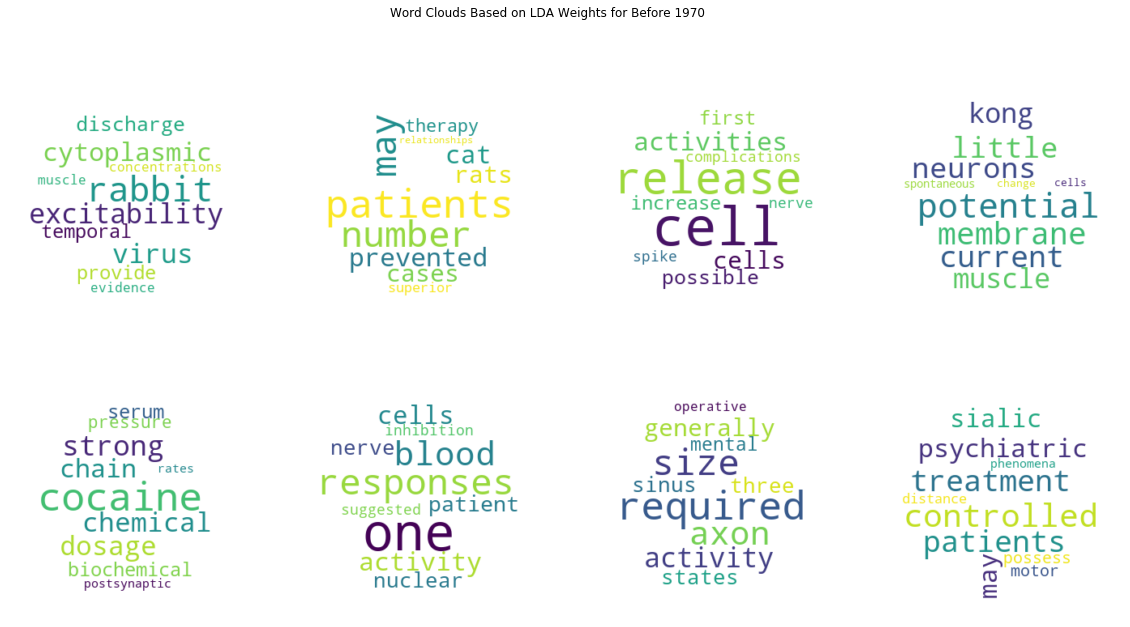

In [5]:
generate_word_cloud(df_before70_topics, 'Before 1970')

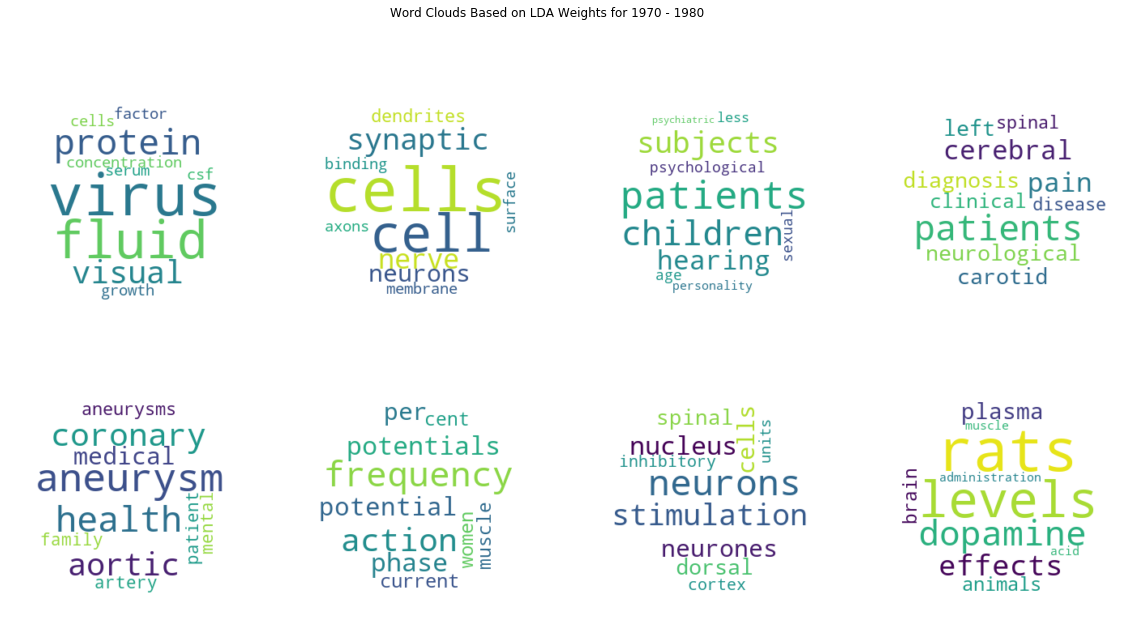

In [6]:
generate_word_cloud(df_7080_topics, '1970 - 1980')

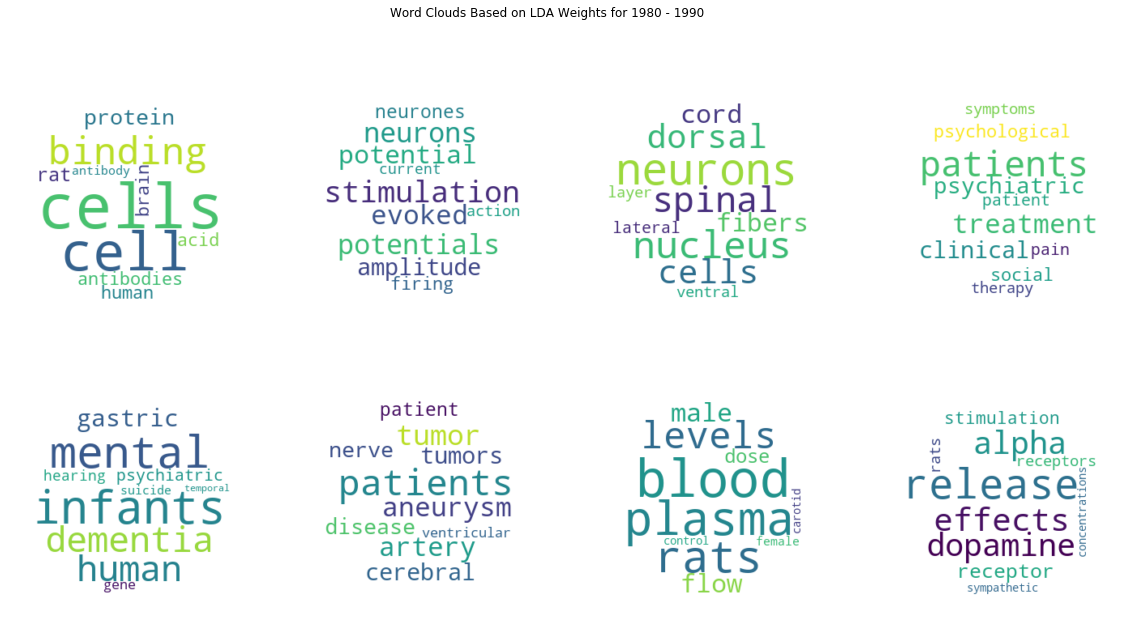

In [7]:
generate_word_cloud(df_8090_topics, '1980 - 1990')

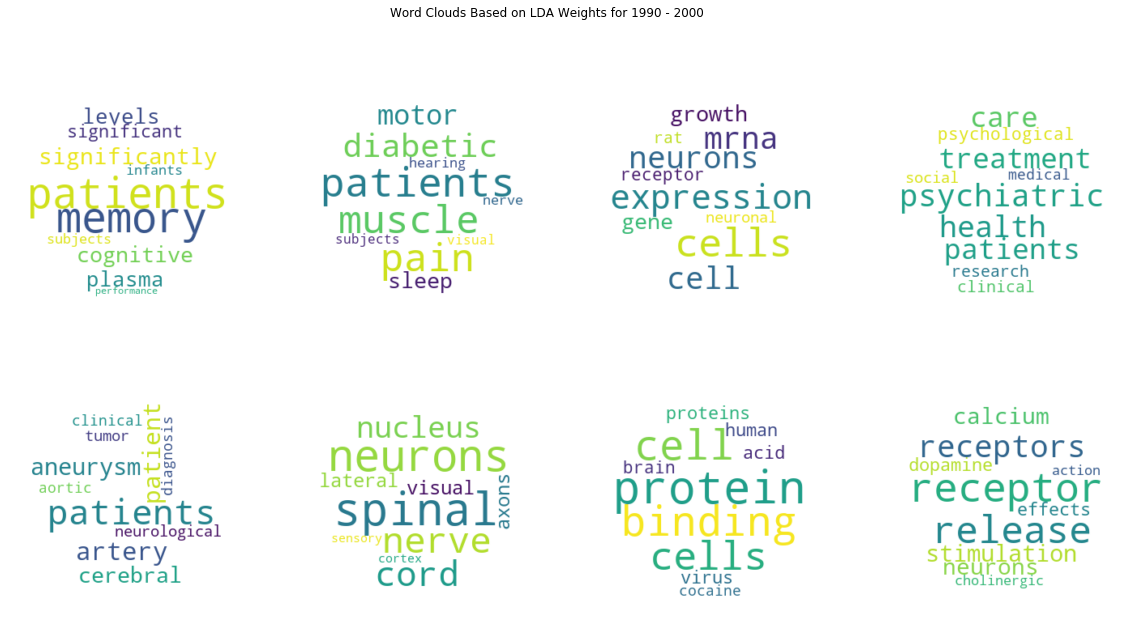

In [8]:
generate_word_cloud(df_9000_topics, '1990 - 2000')

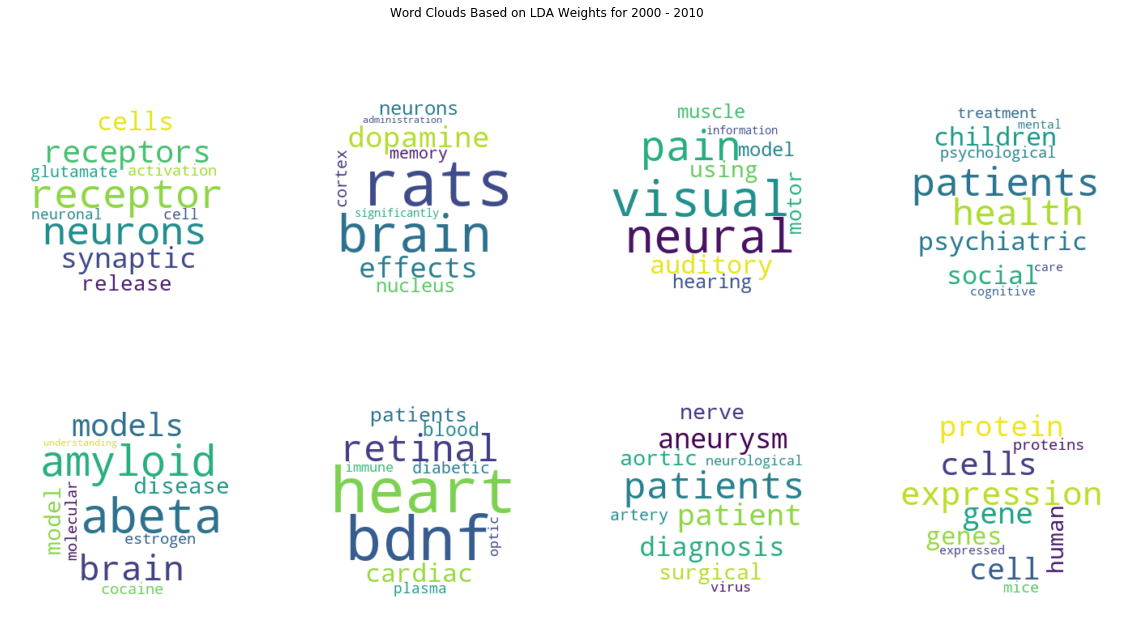

In [9]:
generate_word_cloud(df_0010_topics, '2000 - 2010')

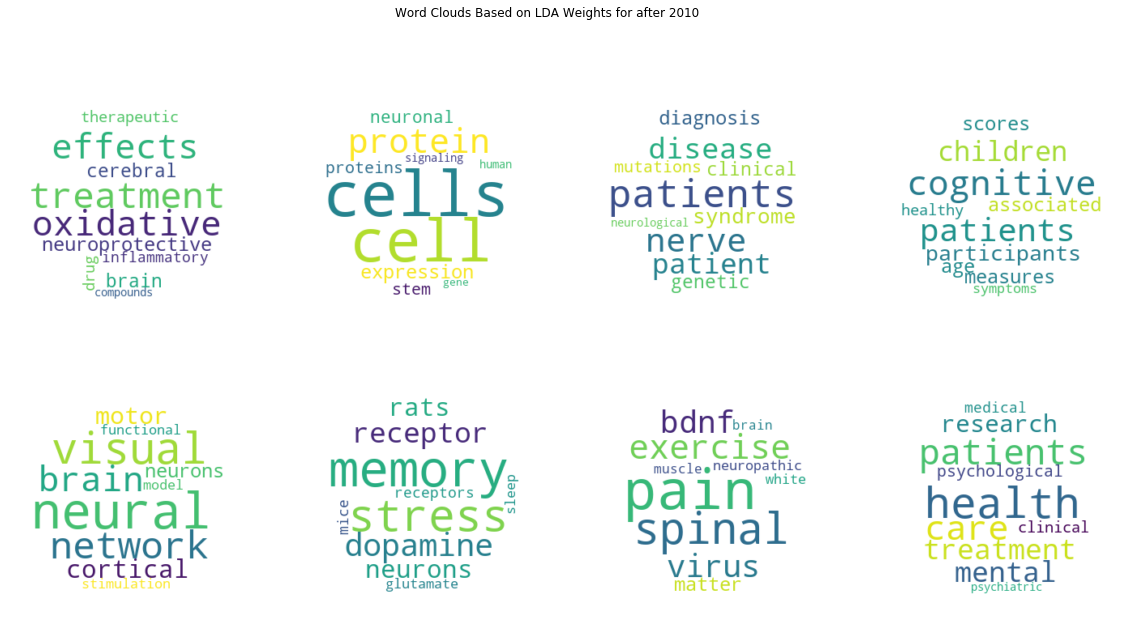

In [10]:
generate_word_cloud(df_after10_topics, 'after 2010')

## Word Embedding Analysis
**How are scientists examining the same topic differently across years?**  

Main topics of interests: mental, alzheimer, and abnormal.

*The following codes were run on an EMR notebook using PySpark*:

In [1]:
#check version
sc.version

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1591062641979_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'2.4.5-amzn-0'

In [90]:
#install necessary packages
#sc.install_pypi_package("pandas")
#sc.install_pypi_package("s3fs")
#sc.install_pypi_package("boto3")
#sc.install_pypi_package("matplotlib")

# import necessary packages
import re as re
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import Word2Vec, PCA
from pyspark.sql import SQLContext
from pyspark import Row
sqlContext = SQLContext(sc)
from pyspark.sql.functions import udf
from pyspark.sql.types import *
import numpy as np
import boto3

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
#Ran the following codes again because I launched a new EMR notebook

#read in data from S3
data = spark.read.csv("s3n://selina-pywren-338/pubmed-psyc-data/data.csv", header=True)
#change year to integer
df = data.withColumn("year", data["pubdate"].cast(IntegerType()))
#create new data by year
data_before70 =  df.filter("year < 1970")
data_7080 = df.filter("year >= 1970 and year < 1980")
data_8090 = df.filter("year >= 1980 and year < 1990")
data_9000 =  df.filter("year >= 1990 and year < 2000")
data_0010 = df.filter("year >= 2000 and year < 2010")
data_after10 =  df.filter("year >= 2010")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [95]:
#use the same method to create tokens:

def create_tokens(StopWords, data):
    #customize create tokens for more accurate results
    tokens = data.rdd.map(
        lambda x : x['abstract']).filter(
        lambda x: x is not None).map(
        lambda document: document.strip().lower()).map(
        lambda document: re.split(" ", document)).map(
        lambda word: [x for x in word if x.isalpha()]).map(
        lambda word: [x for x in word if len(x) > 2]).map(
        lambda word: [x for x in word if x not in StopWords]).zipWithIndex()

    return tokens

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [96]:
def train_word2vec(data):
    #create tokens
    tokens = create_tokens(StopWords,data)
    #create a dataframe
    data_text = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])
    #we will use each abstract as the foundamental unit of text to train the embedding
    doc = data_text.select('list_of_words')
    word2Vec = Word2Vec(vectorSize=5, seed=42, inputCol="list_of_words", outputCol="results")
    model = word2Vec.fit(doc)
    wordVectorsDF = model.getVectors()
    return model, wordVectorsDF

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [101]:
def return_synonyms(model, word, topN):
    #find top n synonyms for a word
    synonyms = model.findSynonyms(word, topN).toPandas()
    return synonyms

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [99]:
#let's train data_before70
model_before70, wvdf_before70 = train_word2vec(data_before70) #ran in less than a minute
print ("Vocabulary Size: ", wvdf_before70.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Vocabulary Size:  875

    As we can see, the vocabulary size here is very small. This is because there are significantly less publications before 70 when compared with the other decades.

In [105]:
#the words alzheimer and mental were not found in before70 data, so let's look at mental
synonyms_mental_before70 = return_synonyms(model_before70, 'mental',10) 
synonyms_mental_before70

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          word  similarity
0    psychotic    0.989485
1   geniculate    0.970594
2        three    0.969684
3        since    0.967741
4      treated    0.963939
5  psychiatric    0.945798
6      members    0.943704
7        glial    0.943315
8         free    0.939168
9     services    0.938498

In [106]:
#let's train data_7080:
model_7080, wvdf_7080 = train_word2vec(data_7080)
print ("Vocabulary Size: ", wvdf_7080.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Vocabulary Size:  8985

In [109]:
#let's look at 'mental' again
synonyms_mental_7080 = return_synonyms(model_7080, 'mental',10)
synonyms_mental_7080

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          word  similarity
0   applicable    0.992386
1         care    0.990944
2      resolve    0.990482
3       states    0.990316
4        asked    0.990215
5  fluoroscopy    0.988398
6       needed    0.987659
7      setting    0.987610
8      relapse    0.986823
9        today    0.986600

In [108]:
#now let's look at alzheimer
synonyms_alzheimer_7080 = return_synonyms(model_7080, 'alzheimer',10)
synonyms_alzheimer_7080

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          word  similarity
0     alkaline    0.997977
1    desirable    0.991022
2        added    0.988666
3    glyoxylic    0.986688
4  elimination    0.984513
5  efficiently    0.983935
6    oxidation    0.983633
7   suspension    0.982340
8    periodate    0.981462
9  equilibrium    0.981461

In [110]:
#now let's look at abnormal
synonyms_abnormal_7080 = return_synonyms(model_7080, 'abnormal',10)
synonyms_abnormal_7080

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

             word  similarity
0            last    0.994673
1       preferred    0.989865
2          myopia    0.986158
3         divided    0.984945
4             fit    0.983737
5       regressed    0.983211
6         unknown    0.982618
7     orthopaedic    0.982572
8  hypothyroidism    0.982553
9           words    0.982152

    We see from the above results that our model is actually rendering quite interesting results. For example, before 1970, the word 'mental''s most similar synonym was 'psychotic', whereas in 70-80 it's 'applicable' and 'care'. However, for 'alzheimer' and 'abnormal', our model is not doing very well. Let's continue to see if it gets better with more data coming from the following decades.

In [111]:
model_8090, wvdf_8090 = train_word2vec(data_8090)
print ("Vocabulary Size: ", wvdf_8090.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Vocabulary Size:  15994

    The vocabulary size is getting much better. Let's find the synonyms.

In [112]:
def find_synonyms(model):
    #let's look at 'mental' again
    mental = return_synonyms(model, 'mental',10)
    alzheimer = return_synonyms(model, 'alzheimer',10)
    abnormal = return_synonyms(model, 'abnormal',10)
    return mental, alzheimer, abnormal

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [113]:
mental_8090, alzheimer_8090, abnormal_8090 = find_synonyms(model_8090)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [114]:
mental_8090

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            word  similarity
0           cost    0.997516
1    situational    0.997437
2      qualified    0.997254
3  maladjustment    0.996797
4     alcoholism    0.996228
5         people    0.996172
6       disorder    0.995956
7           word    0.995616
8         manage    0.995438
9      recruited    0.995340

In [115]:
alzheimer_8090

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                  word  similarity
0              annelid    0.995656
1                  cmv    0.992732
2             organize    0.989907
3  neuropathologically    0.988815
4            hepatitis    0.983152
5            reversion    0.975064
6              semliki    0.974556
7          abandonment    0.963284
8            leukaemia    0.962314
9             maturity    0.962280

In [116]:
abnormal_8090

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

               word  similarity
0          asystole    0.987548
1       irradiation    0.985809
2             later    0.980812
3             laser    0.979930
4  meningomyelocele    0.977162
5           another    0.973331
6             fifth    0.971242
7             noted    0.971085
8            celiac    0.971066
9             stage    0.970795

    Now we are seeing much better results! 'Mental''s most similar synonym is now 'cost' and 'situational'. The fact that 'situational' is up there in the list shows great progress & substantial cultural shift. For alzheimer, we see related words such as 'cmv' (cytomegalovirus infection, which increase alzheimer's risk), 'neuropathologically' and 'abandonment' in the synonym, which intuitively (and sadly, in the case of abandonment) makes sense. For 'abnormal', however, we are still seeing words from all different fields that don't seem to make much sense.

In [117]:
model_9000, wvdf_9000 = train_word2vec(data_9000) 
print ("Vocabulary Size: ", wvdf_9000.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Vocabulary Size:  24253

In [118]:
mental_9000, alzheimer_9000, abnormal_9000 = find_synonyms(model_9000)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [119]:
mental_9000

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

         word  similarity
0    advisors    0.999361
1   financial    0.999260
2      nurses    0.998518
3    offering    0.997657
4    informed    0.997073
5   vignettes    0.996838
6     consent    0.996311
7      duties    0.996205
8       calls    0.996186
9  applicants    0.996122

In [120]:
alzheimer_9000

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                word  similarity
0          newcastle    0.989006
1                scl    0.978717
2           screened    0.977543
3              shore    0.972582
4      promyelocytic    0.970696
5     leukodystrophy    0.968767
6            endorse    0.967614
7                rtt    0.965389
8  multigenerational    0.961682
9              knows    0.958546

In [121]:
abnormal_9000

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

             word  similarity
0       stainless    0.994486
1        cytology    0.991041
2          fruste    0.990458
3           vater    0.990200
4           video    0.985222
5            late    0.982006
6   subclassified    0.981908
7   hemiballismus    0.979936
8      guarantees    0.979609
9  extraforaminal    0.975690

    Some interesting pattern to note here: Alzheimer research is definitely progressing. We see words such as 'multigenerational' ,'rtt' (or Rett Syndrome, a neurodevelopmental disorder characterized by normal early psychomotor development), and 'leukodystrophy' (according to Wikipedia, is a group of rare, progressive, metabolic, genetic diseases that affect the brain, spinal cord and often the peripheral nerves) as the top synonyms. This means that our researchers had begin to realize that Alzheimer is a progressive, genetic, brain-related disease.

In [122]:
model_0010, wvdf_0010 = train_word2vec(data_0010) 
#as number of publications increases, it took a little longer to train (about 2 minutes)
print ("Vocabulary Size: ", wvdf_0010.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Vocabulary Size:  29987

In [123]:
mental_0010, alzheimer_0010, abnormal_0010 = find_synonyms(model_0010)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [124]:
mental_0010

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           word  similarity
0       welfare    0.998368
1      alliance    0.998236
2    supportive    0.998204
3  announcement    0.996551
4  dispositions    0.996072
5     objectify    0.995649
6         unmet    0.995394
7        safety    0.994998
8    caregiving    0.994920
9     community    0.994829

In [125]:
alzheimer_0010

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            word  similarity
0     autoimmune    0.994168
1  provisionally    0.984787
2            vsp    0.982683
3     infectious    0.982446
4    progression    0.981692
5     millennium    0.980344
6     recognized    0.976911
7        disease    0.976163
8     pejorative    0.975901
9       diseases    0.975734

In [126]:
abnormal_0010

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                    word  similarity
0              ultrafine    0.987578
1             precocious    0.987300
2                innocua    0.985736
3          extrapolating    0.983501
4              allegedly    0.982127
5                    der    0.979466
6            centromeric    0.979247
7            embryologic    0.978305
8              digestive    0.978137
9  mucopolysaccharidosis    0.976334

In [127]:
model_after10, wvdf_after10 = train_word2vec(data_after10) 
print ("Vocabulary Size: ", wvdf_after10.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Vocabulary Size:  38134

In [128]:
mental_after10, alzheimer_after10, abnormal_after10 = find_synonyms(model_after10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [129]:
mental_after10

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            word  similarity
0          stave    0.994489
1         health    0.994171
2   psychosocial    0.993910
3     lifestyles    0.992894
4        lebanon    0.992530
5       narrated    0.991415
6          psrfs    0.991413
7           rita    0.991092
8    bereavement    0.989977
9  affordability    0.988072

In [130]:
alzheimer_after10

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                word  similarity
0     neurometabolic    0.993835
1  microbiologically    0.993593
2            fragile    0.993417
3          foodborne    0.987663
4               rett    0.984513
5            disease    0.982809
6            wolfram    0.981952
7          affecting    0.980769
8       fibrinolytic    0.980083
9   encephalopathies    0.978776

In [132]:
abnormal_after10

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

               word  similarity
0        quinolones    0.998634
1          acylated    0.998501
2      pentapeptide    0.998122
3       congophilic    0.997481
4              ascs    0.996644
5     myoinhibitory    0.992948
6      glycosylated    0.992174
7      heptapeptide    0.992013
8           dodecyl    0.990582
9  vasoconstrictive    0.990035

    From the above results, we see that each decade's embedding model returned different synonyms that are getting increasingly close to our current interpretation of these words. For the synonyms returned by after10, we see that 'mental''s synonyms are words like 'bereavement', 'psychosocial', 'lifestyle', and 'narrated', which is doing much better than the initial top synonym 'psychotic' that before70 word2vec model returned. In terms of 'alzheimer', the word is becoming more accurately identified as a neurodegenerative disease that's similar to Rett syndrome and Wolfram syndrome. For the word 'abnormal', we are now seeing synonyms like 'quinolones', 'vasoconstrictive', 'acylated', which are related to abnormal biological/neurological diseases, instead of random words returned by previous models.